<a href="https://colab.research.google.com/github/SEBADA321/codonusagebias/blob/main/Codon_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sklearn as sk
import joblib
from google.colab import files
from sklearn.ensemble import RandomForestClassifier 
import pickle


data1 = pd.read_csv('https://drive.google.com/uc?export=download&id=1Z4v43cvTwp920NyOdboDKP7_ytC_0tBC')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data1.head(5)

Kingdom  DNAtype  SpeciesID  Ncodons  ...      GAG      UAA      UAG      UGA
0     vrl        0     100217     1995  ...  0.04361  0.00251  0.00050  0.00000
1     vrl        0     100220     1474  ...  0.04410  0.00271  0.00068  0.00000
2     vrl        0     100755     4862  ...  0.02468  0.00391  0.00000  0.00144
3     vrl        0     100880     1915  ...  0.03446  0.00261  0.00157  0.00000
4     vrl        0     100887    22831  ...  0.03679  0.00000  0.00044  0.00131

[5 rows x 69 columns]

# Descripción:

The 'Kingdom' is a 3-letter code corresponding to `xxx' in the CUTG database name: 'arc'(archaea), 'bct'(bacteria), 'phg'(bacteriophage), 'plm' (plasmid), 'pln' (plant), 'inv' (invertebrate), 'vrt' (vertebrate), 'mam' (mammal), 'rod' (rodent), 'pri' (primate), and 'vrl'(virus) sequence entries. Note that the CUTG database does not contain 'arc' and 'plm' (these have been manually curated ourselves).

The 'DNAtype' is denoted as an integer for the genomic composition in the species: 0-genomic, 1-mitochondrial, 2-chloroplast, 3-cyanelle, 4-plastid, 5-nucleomorph, 6-secondary_endosymbiont, 7-chromoplast, 8-leucoplast, 9-NA, 10-proplastid, 11-apicoplast, and 12-kinetoplast.

The species identifier ('SpeciesID') is an integer, which uniquely indicates the entries of an organism. It is an accession identifier for each different species in the original CUTG database, followed by the first item listed in each genome.

The number of codons (`Ncodons') is the algebraic sum of the numbers listed for the different codons in an entry of CUTG. Codon frequencies are normalized to the total codon count, hence the number of occurrences divided by 'Ncodons' is the codon frequencies listed in the data file.

The species' name ('SpeciesName') is represented in strings purged of `comma` (which are now replaced by `space`). This is a descriptive label of the name of the species for data interpretations.

Lastly, the codon frequencies ('codon') including 'UUU', 'UUA', 'UUG', 'CUU', etc., are recorded as floats (with decimals in 5 digits).



In [40]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, MultiLabelBinarizer
import tensorflow as tf
data1

Kingdom  DNAtype  SpeciesID   Ncodons  ...      GAG      UAA      UAG      UGA
0         vrl        0     100217      1995  ...  0.04361  0.00251  0.00050  0.00000
1         vrl        0     100220      1474  ...  0.04410  0.00271  0.00068  0.00000
2         vrl        0     100755      4862  ...  0.02468  0.00391  0.00000  0.00144
3         vrl        0     100880      1915  ...  0.03446  0.00261  0.00157  0.00000
4         vrl        0     100887     22831  ...  0.03679  0.00000  0.00044  0.00131
...       ...      ...        ...       ...  ...      ...      ...      ...      ...
13023     pri        0       9601      1097  ...  0.04102  0.00091  0.00091  0.00638
13024     pri        1       9601      2067  ...  0.00677  0.00242  0.00097  0.01887
13025     pri        1       9602      1686  ...  0.00297  0.00356  0.00119  0.02017
13026     pri        0       9606  40662582  ...  0.03959  0.00099  0.00079  0.00156
13027     pri        1       9606   8998998  ...  0.00783  0.00156  0.00114  0.02161

[13028 rows x 69 columns]

In [4]:
def ML_prepocess(data):
  ml_data = data.copy()
  ml_data.Kingdom = ml_data.Kingdom.astype('category')
  drop_col = ['SpeciesID','SpeciesName']
  print("Columnas eliminadas:", drop_col)
  ml_data.drop(drop_col,inplace=True, axis=1)

  ml_data[['UUU', 'UUC']] = ml_data[['UUU', 'UUC']].apply(pd.to_numeric, errors='coerce')
  criteria = ~ml_data.isna()
  ml_data = ml_data[criteria['UUU']]
  ml_data = ml_data[criteria['UUC']]
  return ml_data

In [5]:
ml_data = ML_prepocess(data1)
ml_data.head(5)

Columnas eliminadas: ['SpeciesID', 'SpeciesName']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


Kingdom  DNAtype  Ncodons      UUU  ...      GAG      UAA      UAG      UGA
0     vrl        0     1995  0.01654  ...  0.04361  0.00251  0.00050  0.00000
1     vrl        0     1474  0.02714  ...  0.04410  0.00271  0.00068  0.00000
2     vrl        0     4862  0.01974  ...  0.02468  0.00391  0.00000  0.00144
3     vrl        0     1915  0.01775  ...  0.03446  0.00261  0.00157  0.00000
4     vrl        0    22831  0.02816  ...  0.03679  0.00000  0.00044  0.00131

[5 rows x 67 columns]

In [6]:
ml_data.dtypes

Kingdom    category
DNAtype       int64
Ncodons       int64
UUU         float64
UUC         float64
             ...   
GAA         float64
GAG         float64
UAA         float64
UAG         float64
UGA         float64
Length: 67, dtype: object

In [7]:
def Create_X_Y(ml_data, target_col):
  x = ml_data.drop(target_col, axis=1)
  y = ml_data[target_col]

  #enc = OneHotEncoder(handle_unknown='ignore')
  #enc.fit(y)
  #print(enc.categories_)
  #dummy_y = enc.transform(y)

  #encoder = LabelEncoder()
  #encoder.fit(y[target_col[0]])
  #encoded_Y = encoder.transform(y[target_col[0]])
  #dummy_y = tf.keras.utils.to_categorical(encoded_Y, num_classes=y.value_counts().index.shape[0])

  lb = LabelBinarizer()
  lb.fit(y[target_col[0]])
  print(lb.classes_)
  dummy_y = lb.transform(y[target_col[0]])
  df_y_1 = pd.DataFrame(dummy_y, columns = lb.classes_)
  
  lb.fit(y[target_col[1]])
  print(lb.classes_)
  dummy_y = lb.transform(y[target_col[1]])
  df_y_2 = pd.DataFrame(dummy_y, columns = lb.classes_)
  result = pd.concat([df_y_1, df_y_2], axis=1)

  #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=70)
  return x, df_y_1, df_y_2, result

In [31]:
target_col = ['Kingdom', 'DNAtype']
X, df_y_1, df_y_2, Y = Create_X_Y(ml_data, target_col)
Y

['arc' 'bct' 'inv' 'mam' 'phg' 'plm' 'pln' 'pri' 'rod' 'vrl' 'vrt']
[ 0  1  2  3  4  5  6  7  9 11 12]


arc  bct  inv  mam  phg  plm  pln  pri  rod  ...  2  3  4  5  6  7  9  11  12
0        0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
1        0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
2        0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
3        0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
4        0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ... .. .. .. .. .. .. ..  ..  ..
13021    0    0    0    0    0    0    0    1    0  ...  0  0  0  0  0  0  0   0   0
13022    0    0    0    0    0    0    0    1    0  ...  0  0  0  0  0  0  0   0   0
13023    0    0    0    0    0    0    0    1    0  ...  0  0  0  0  0  0  0   0   0
13024    0    0    0    0    0    0    0    1    0  ...  0  0  0  0  0  0  0   0   0
13025    0    0    0    0    0    0    0    1    0  ...  0  0  0  0  0  0  0   0   0

[13026 rows x 22 columns]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=70)
dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))
train_dataset = dataset.shuffle(len(X) + len(Y), reshuffle_each_iteration=True).batch(1)

In [50]:
def get_compiled_model():
  ml_model = tf.keras.Sequential([
    #tf.keras.layers.BatchNormalization(input_shape=(preprocessed_dataset.shape[1]-1,)),
    tf.keras.layers.Dense(20, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(20, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(20, activation='relu'),
    #tf.keras.layers.Dropout(.2),
    #tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(22, activation='sigmoid')
  ])

  ml_model.compile(optimizer='adam',
                loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')])
  return ml_model

In [51]:
ml_model = get_compiled_model()
hist = ml_model.fit(train_dataset, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
10420/10420 [==============================] - 15s 1ms/step - loss: 12.0223 - auc: 0.7733 - accuracy: 0.1431 - val_loss: 0.2272 - val_auc: 0.8931 - val_accuracy: 0.0000e+00
Epoch 2/10
10420/10420 [==============================] - 14s 1ms/step - loss: 0.1930 - auc: 0.8984 - accuracy: 0.0000e+00 - val_loss: 0.1923 - val_auc: 0.8992 - val_accuracy: 0.0000e+00
Epoch 3/10
10420/10420 [==============================] - 14s 1ms/step - loss: 0.1914 - auc: 0.9002 - accuracy: 8.7245e-05 - val_loss: 0.1920 - val_auc: 0.8996 - val_accuracy: 0.0000e+00
Epoch 4/10
10420/10420 [==============================] - 25s 2ms/step - loss: 0.1911 - auc: 0.9001 - accuracy: 0.0000e+00 - val_loss: 0.1922 - val_auc: 0.8988 - val_accuracy: 0.0000e+00
Epoch 5/10
10420/10420 [==============================] - 15s 1ms/step - loss: 0.1911 - auc: 0.9000 - accuracy: 0.0000e+00 - val_loss: 0.1920 - val_auc: 0.8994 - val_accuracy: 0.0000e+00
Epoch 6/10
10420/10420 [==============================] - 14s 1ms/st

In [52]:
ml_model.evaluate(x_test, y_test)

82/82 [==============================] - 0s 3ms/step - loss: 0.1921 - auc: 0.8989 - accuracy: 0.0000e+00


[0.19211925566196442, 0.8989303112030029, 0.0]

In [111]:
def get_compiled_model_2_output():
  inp = tf.keras.layers.Input(shape=(65,))
  l_x = tf.keras.layers.Dense(20, activation='relu', name= 'layer_1')(inp)
  l_x = tf.keras.layers.Dense(20, activation='relu')(l_x)
  
  l_Kingdom = tf.keras.layers.Dense(20, activation='relu', name= 'K_1')(l_x)
  l_Kingdom = tf.keras.layers.Dense(11, activation='softmax', name= 'K_out')(l_Kingdom)
  
  l_DNAtype = tf.keras.layers.Dense(20, activation='relu', name= 'DNA_1')(l_x)
  l_DNAtype = tf.keras.layers.Dense(11, activation='softmax', name= 'DNA_out')(l_DNAtype)

  ml_model = tf.keras.Model(inputs=inp, outputs=[l_Kingdom, l_DNAtype])

  ml_model.compile(optimizer='adam',
                loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Accuracy(name='accuracy')])
  return ml_model

In [ ]:
y_DNA_train

In [106]:
x_train, x_test, y_K_train, y_K_test, y_DNA_train, y_DNA_test = train_test_split(X, df_y_1, df_y_2, test_size=0.2, random_state=70)
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_K_train, y_DNA_train))
train_dataset = dataset.shuffle(len(X) + len(df_y_1) + + len(df_y_2), reshuffle_each_iteration=True).batch(1)

In [ ]:
ml_model = get_compiled_model_2_output()
#hist = ml_model.fit(x_train, [y_K_train, y_DNA_train], validation_data=(x_test, y_K_test, y_DNA_test), epochs=10)
hist = ml_model.fit(x_train, [y_K_train, y_DNA_train], epochs=10)

In [143]:
tf_prediction = ml_model.predict(x_test)
tf_prediction = tf.cast(tf.greater(tf_prediction, 0.5), tf.int32).numpy()
test_1 = pd.DataFrame(data= tf_prediction[0], columns = df_y_1.columns)#, columns = lb.classes_)
test_2 = pd.DataFrame(data= tf_prediction[1], columns = df_y_2.columns)#, columns = lb.classes_)
test_3 = pd.concat([test_1, test_2], axis=1)

In [149]:
y_K_test

arc  bct  inv  mam  phg  plm  pln  pri  rod  ...  2  3  4  5  6  7  9  11  12
3849     0    1    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
5344     0    1    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
434      0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
1425     0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
8889     0    0    1    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ... .. .. .. .. .. .. ..  ..  ..
12069    0    0    0    1    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
11109    0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
8707     0    0    1    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
2045     0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
12292    0    0    0    1    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0

[2606 rows x 22 columns]

In [142]:
test_3

arc  bct  inv  mam  phg  plm  pln  pri  rod  ...  2  3  4  5  6  7  9  11  12
0       0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
1       0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
2       0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
3       0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
4       0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ... .. .. .. .. .. .. ..  ..  ..
2601    0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
2602    0    1    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
2603    0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
2604    0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0
2605    0    0    0    0    0    0    0    0    0  ...  0  0  0  0  0  0  0   0   0

[2606 rows x 22 columns]

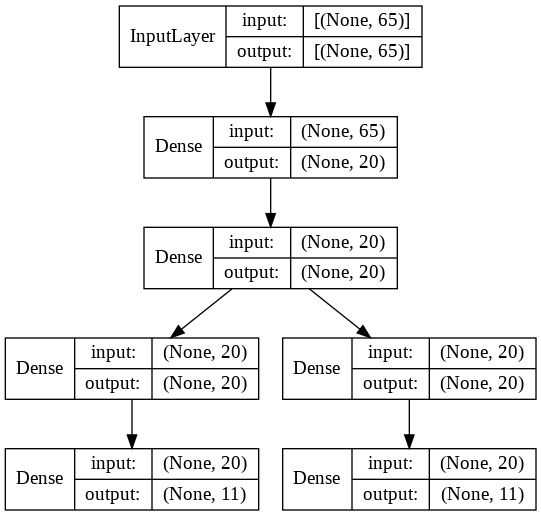

In [112]:
tf.keras.utils.plot_model(ml_model, to_file="model.png", show_shapes=True, expand_nested=True, show_layer_names=False)

In [70]:
list(dataset.as_numpy_iterator())[0]

(array([1.995e+03, 1.654e-02, 1.203e-02, 5.000e-04, 3.510e-03, 1.203e-02,
        3.208e-02, 1.000e-03, 4.010e-02, 5.510e-03, 2.005e-02, 7.520e-03,
        2.506e-02, 1.103e-02, 4.110e-02, 9.020e-03, 3.308e-02, 1.003e-02,
        5.013e-02, 1.554e-02, 1.103e-02, 2.356e-02, 3.208e-02, 1.203e-02,
        5.010e-03, 1.003e-02, 1.203e-02, 3.158e-02, 1.905e-02, 2.456e-02,
        1.353e-02, 2.155e-02, 2.510e-03, 6.520e-03, 1.500e-03, 1.554e-02,
        5.010e-03, 2.105e-02, 9.020e-03, 1.053e-02, 5.010e-03, 2.256e-02,
        3.010e-03, 3.108e-02, 4.010e-03, 2.607e-02, 2.510e-03, 1.153e-02,
        5.010e-03, 2.356e-02, 1.053e-02, 3.860e-02, 4.010e-03, 7.020e-03,
        4.010e-03, 4.510e-03, 1.303e-02, 3.559e-02, 1.003e-02, 4.612e-02,
        1.203e-02, 4.361e-02, 2.510e-03, 5.000e-04, 0.000e+00]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))